<a href="https://colab.research.google.com/github/hyeonjusong410/DL.Basic/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp "/content/drive/MyDrive/Colab Notebooks/DL_Basic/SE_dataset.zip" /content/
!cp "/content/drive/MyDrive/Colab Notebooks/DL_Basic/bilinear_upsampled_VGG16.pth" /content/
!cp "/content/drive/MyDrive/Colab Notebooks/DL_Basic/functions.py" /content/


In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/DL_Basic/SE_dataset.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img/2011_001600.jpg     
  inflating: img/2011_001601.jpg     
  inflating: img/2011_001602.jpg     
  inflating: img/2011_001605.jpg     
  inflating: img/2011_001606.jpg     
  inflating: img/2011_001607.jpg     
  inflating: img/2011_001608.jpg     
  inflating: img/2011_001610.jpg     
  inflating: img/2011_001611.jpg     
  inflating: img/2011_001612.jpg     
  inflating: img/2011_001613.jpg     
  inflating: img/2011_001614.jpg     
  inflating: img/2011_001616.jpg     
  inflating: img/2011_001618.jpg     
  inflating: img/2011_001619.jpg     
  inflating: img/2011_001620.jpg     
  inflating: img/2011_001621.jpg     
  inflating: img/2011_001622.jpg     
  inflating: img/2011_001624.jpg     
  inflating: img/2011_001625.jpg     
  inflating: img/2011_001627.jpg     
  inflating: img/2011_001628.jpg     
  inflating: img/2011_001629.jpg     
  inflating: img/2011_001632.jpg     
  inflating: img/2011_001637.jpg     
  inflating: i

In [5]:
from io import IncrementalNewlineDecoder
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
import functions

## Section 1.  per-pixel classification

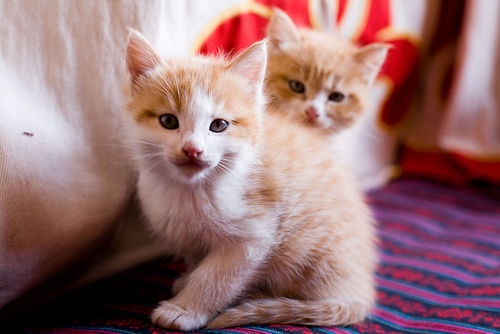

In [10]:
from PIL import Image
test_img_path = './img/2007_000876.jpg'
test_img = Image.open(test_img_path)
test_img

#### Image Normalize

In [7]:
import torchvision.transforms as transforms
nomal = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imageNet RGB mean, std

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    nomal,
])

test_transform = transform(test_img).cuda().unsqueeze(0) # unsqueeze(0) :  add a batch dim
print(test_transform.size())

torch.Size([1, 3, 224, 224])


#### Loading VGG-Net

In [11]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 71.0MB/s]


In [13]:
import torch
import torch.nn as nn
with torch.no_grad():
  out = imageNet(test_transform)

  out_class = torch.argmax(out)
  print(out.size())
  print(out_class)

torch.Size([1, 1000])
tensor(287, device='cuda:0')


In [15]:
# moderately padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
img_1by1 = torch.zeros((224,224)).cuda()


In [17]:
# Calculate each pixelfor
for i  in range(224):
  for j in range(224):
    patch = pad_image[:, :, i:i+224, j:j+224]
    # classify each pixels
    with torch.no_grad():
      img_1by1[i, j] = torch.argmax(imageNet(patch))

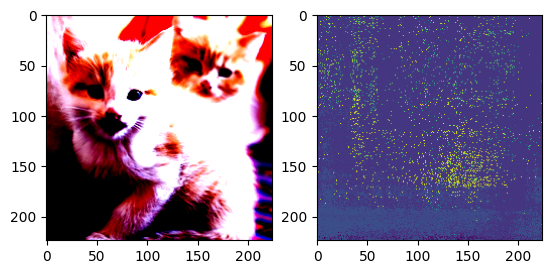

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(img_1by1.data.cpu().numpy())
plt.show()
# Low Accuracy

## Section 2. Replace the final FC layer with a 1×1 conv, without up/downsampling.

In [23]:
import torchvision.models as models

class VGG_only_C(nn.Module):
  def __init__(self):
    super(VGG_only_C, self).__init__()
    self.features = models.vgg16(pretrained=True).features

    #fine-tuninig
    # fc6
    self.fc6 = nn.Conv2d(512, 4096, 7)

    # fc7
    self.fc7 = nn.Conv2d(4096, 4096, 1)

    # fc8
    self.fc8 = nn.Conv2d(4096, 1000, 1)

    # Relu
    self.relu = nn.ReLU(inplace=True)

    # Dropout
    self.dropout = nn.Dropout()

    self.copy_params_from_vgg16()

  def forward(self, x):
    conv5 = self.features(x)

    fc6 = self.relu(self.fc6(conv5))
    fc7 = self.dropout(fc6)

    fc7 = self.relu(self.fc7(fc7))
    fc8 = self.dropout(fc7) # 1x1

    score = self.fc8(fc8)

    return score

  def copy_params_from_vgg16(self):
    vgg16 = models.vgg16(pretrained=True)
    for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
      I1 = vgg16.classifier[i]
      I2 = getattr(self, name)
      I2.weight.data.copy_(I1.weight.data.view(I2.weight.size()))
      I2.bias.data.copy_(I1.bias.data.view(I2.bias.size()))

In [24]:
vgg_only = VGG_only_C().cuda()
vgg_only

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG_only_C(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [26]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    nomal,
])

test_conv = transform_conv(test_img).cuda().unsqueeze(0)
conv_out = vgg_only(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred
# image size error

tensor([[[277, 287, 277, 287, 287, 287, 287, 281, 281],
         [279, 937, 277, 287, 287, 282, 937, 769, 287],
         [277, 277, 285, 287, 287, 287, 285, 282, 285],
         [356, 277, 356, 356, 356, 285, 282, 285, 287]]], device='cuda:0')

###

## Section 3. Upsampling to Bilinear interpolation

In [31]:
class bilinear_upsampled_VGG16(nn.Module):
  def __init__(self):
    super(bilinear_upsampled_VGG16, self).__init__()
    self.features = models.vgg16(pretrained=True).features
    self.features[0].padding = (100, 100) # padding setting to fit the image size

    #fine-tuninig
    # fc6
    self.fc6 = nn.Conv2d(512, 4096, 7)

    # fc7
    self.fc7 = nn.Conv2d(4096, 4096, 1)

    # fc8 : output channels are set to '21' for PASCAL VOC class
    self.fc8 = nn.Conv2d(4096, 21, 1)

    # Relu
    self.relu = nn.ReLU(inplace=True)

    # Dropout
    self.dropout = nn.Dropout()

    # scaling factor : 32,  upsample layer define bilinear interpolation
    self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)

    self.copy_params_from_vgg16()

  def forward(self, x):
    conv5 = self.features(x)

    fc6 = self.relu(self.fc6(conv5))
    fc7 = self.dropout(fc6)

    score = self.fc8(fc7)

    input_size = x.size()[2:]
    upsampled_score = self.upsample(score)
    return upsampled_score

  def copy_params_from_vgg16(self):
    vgg16 = models.vgg16(pretrained=True)
    for i, name in zip([0, 3, 6], ['fc6', 'fc7']):
      I1 = vgg16.classifier[i]
      I2 = getattr(self, name)
      I2.weight.data.copy_(I1.weight.data.view(I2.weight.size()))
      I2.bias.data.copy_(I1.bias.data.view(I2.bias.size()))

In [32]:
bilinear_upsample = bilinear_upsampled_VGG16().cuda()
model_data = torch.load('./bilinear_upsampled_VGG16.pth')
bilinear_upsample.load_state_dict(model_data)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

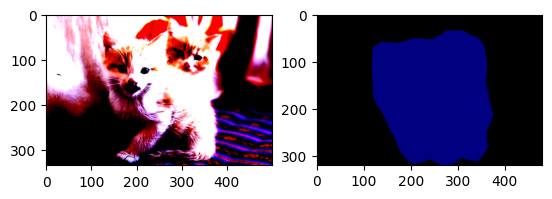

In [33]:
with torch.no_grad():
    conv_out = bilinear_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = functions.segmentation_output(output[0].data.cpu().numpy())

plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

Section 4. CNN with Encoder/Decoder

In [35]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()

        self.features = models.vgg16(pretrained=True).features

        # fc6 layer
        self.fc6 = nn.Conv2d(512, 4096, 7)


        # fc6 layer
        self.fc7 = nn.Conv2d(4096, 4096, 1)


        # ReLU
        self.relu = nn.ReLU(inplace=True)

        # Dropout
        self.dropout = nn.Dropout2d()


        #Downsampling
        self.predict_conv1 = nn.Conv2d(4096, n_class, kernel_size=1)
        self.predict_conv2 = nn.Conv2d(512, n_class, kernel_size=1)
        self.predict_conv3 = nn.Conv2d(256, n_class, kernel_size=1)

        # Upscaling
        self.deconv1 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, kernel_size=16, stride=8, bias=False)

        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)

        # MaxPool2d layer & ConvTranspose2d layer initialize
        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode = True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = functions.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        initial = x
        # VGG passing, pool3 & pool4 results save
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 16:
                pool3 = x.clone()
            elif idx == 23:
                pool4 = x.clone()

        # Pass through fc6 layer
        x = self.dropout(self.relu(self.fc6(x)))

        # Pass through fc7 layer
        x = self.dropout(self.relu(self.fc7(x)))

        # Pass through Prediction 1 and Deconvolution 1
        x = self.predict_conv1(x)
        x = self.deconv1(x)
        deconv1 = x

        # Pass through Prediction 2
        x = self.predict_conv2(pool4)
        x = x[:, :, 5:5 + deconv1.size(2), 5:5 + deconv1.size(3)] # Crop boundary
        predict2 = x

        # Add deconv1 and predict2, then pass through Deconvolution 2
        x = deconv1 + predict2 * 0.01
        x = self.deconv2(x)
        deconv2 = x

        # Pass through Prediction 3
        x = self.predict_conv3(pool3)
        x = x[:, :, 9:9 + deconv2.size(2), 9:9 + deconv2.size(3)] # Crop boundary
        predict3 = x

        # Add predict3 and deconv2
        x = predict3 * 0.0001 + deconv2

        # Pass through Deconvolution 3
        x = self.deconv3(x)
        x = x[:, :, 31:31+initial.size(2), 31:31+initial.size(3)].contiguous() # Crop boundary
        return x

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [36]:
img_list = functions.read_file('./list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = functions.chunker(data_list, 1)

In [37]:
model = FCN8s().cuda()